In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# show plots inline
%matplotlib inline

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'data')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')

# directories exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Figures directory: {FIGURES_DIR}")

Data directory: /Users/daeseolee/Documents/Exploratory-Data-Analysis-on-Prices/data
Figures directory: /Users/daeseolee/Documents/Exploratory-Data-Analysis-on-Prices/figures


In [2]:
tickers = ['AAPL', 'MSFT', 'GOOG']
start_date = '2018-01-01'
end_date = '2023-12-31'

prices_df = yf.download(
    tickers,
    start = start_date,
    end = end_date,
    progress = False,
    auto_adjust = False
)

raw_path = os.path.join(DATA_DIR, 'prices_raw.csv')
prices_df.to_csv(raw_path)
print(f"Downloaded {len(prices_df)} rows for {tickers} and saved to:\n{raw_path}")

Downloaded 1509 rows for ['AAPL', 'MSFT', 'GOOG'] and saved to:
/Users/daeseolee/Documents/Exploratory-Data-Analysis-on-Prices/data/prices_raw.csv


In [3]:
raw_path = os.path.join(DATA_DIR, 'prices_raw.csv')
df = pd.read_csv(raw_path, header=[0,1], index_col=0, parse_dates=True)

print(df.head())
print("\nData info:")
print(df.info())

# complete business day index 
all_days = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')

tickers = df.columns.get_level_values(1).unique()
reindexed_list = []

for t in tickers:
    # Slice out all columns for this ticker
    df_t = df.xs(t, axis=1, level=1)
    # Reindex to full calendar
    df_t = df_t.reindex(all_days)
    # After reindex, reattach the ticker level
    df_t.columns = pd.MultiIndex.from_product([df_t.columns, [t]])
    reindexed_list.append(df_t)

# Concatenate back into one DataFrame
df = pd.concat(reindexed_list, axis=1)

# NaNs
print("\nMissing values per column:")
print(df.isna().sum())

# Fill forward then backward
df.ffill(inplace=True)
df.bfill(inplace=True)

# Verify no more nulls
print("\nPost-fill missing values per column:")
print(df.isna().sum())

Price       Adj Close                            Close                        \
Ticker           AAPL       GOOG       MSFT       AAPL       GOOG       MSFT   
Date                                                                           
2018-01-02  40.426815  52.935341  79.328514  43.064999  53.250000  85.949997   
2018-01-03  40.419788  53.804180  79.697723  43.057499  54.124001  86.349998   
2018-01-04  40.607533  53.999020  80.399147  43.257500  54.320000  87.110001   
2018-01-05  41.069866  54.785843  81.395958  43.750000  55.111500  88.190002   
2018-01-08  40.917309  55.019951  81.479012  43.587502  55.347000  88.279999   

Price            High                              Low                        \
Ticker           AAPL       GOOG       MSFT       AAPL       GOOG       MSFT   
Date                                                                           
2018-01-02  43.075001  53.347000  86.309998  42.314999  52.261501  85.500000   
2018-01-03  43.637501  54.314499  86.51

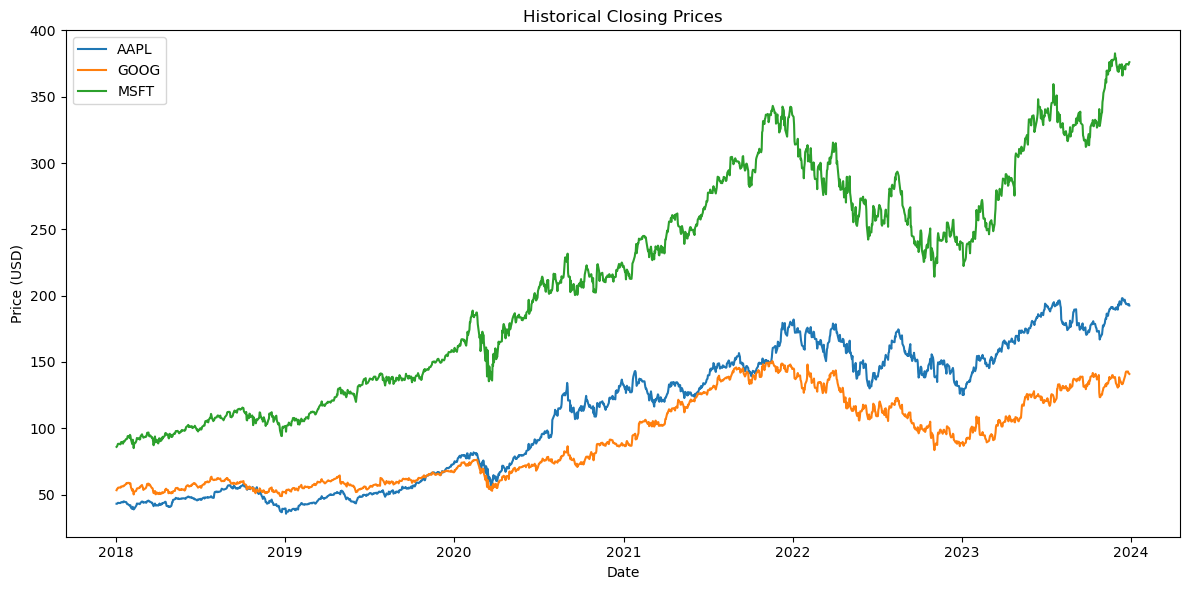

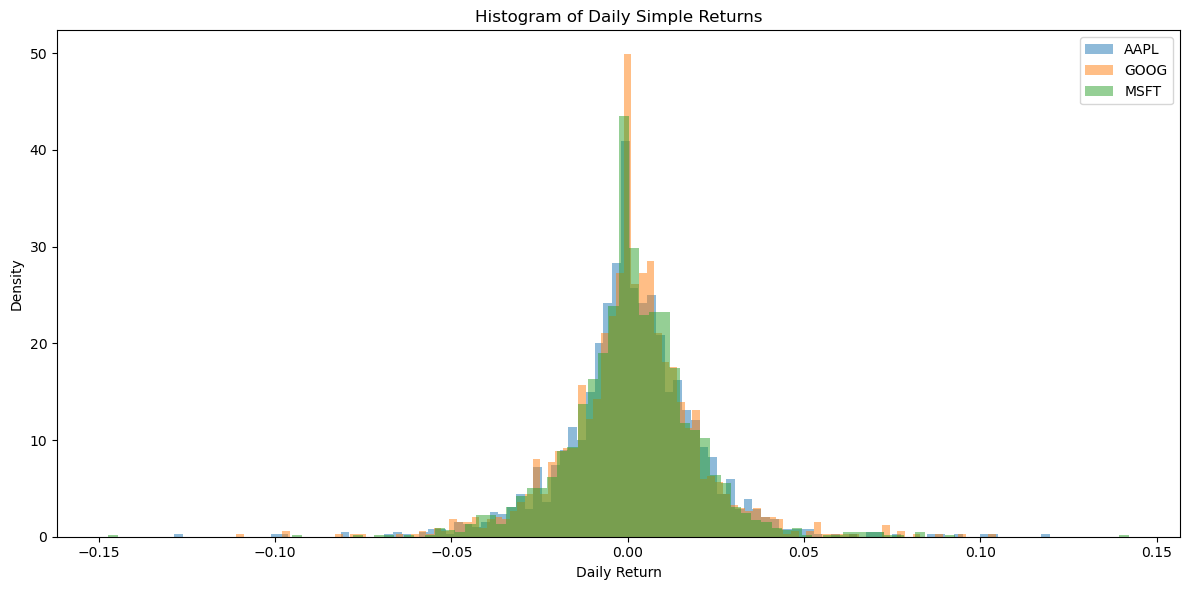

In [4]:
close = df['Close'].copy()

# daily simple and log returns
simple_ret = close.pct_change().dropna()
log_ret = np.log(close / close.shift(1)).dropna()

# Closing Prices Time Series
plt.figure(figsize=(12, 6))
for ticker in close.columns:
    plt.plot(close.index, close[ticker], label=ticker)
plt.title('Historical Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'closing_prices.png'))
plt.show()

# Daily Return Distributions
plt.figure(figsize=(12, 6))
for ticker in simple_ret.columns:
    plt.hist(simple_ret[ticker], bins=100, alpha=0.5, density=True, label=ticker)
plt.title('Histogram of Daily Simple Returns')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'return_histograms.png'))
plt.show()

Saved 20-day moving averages and rolling vols to /Users/daeseolee/Documents/Exploratory-Data-Analysis-on-Prices/data


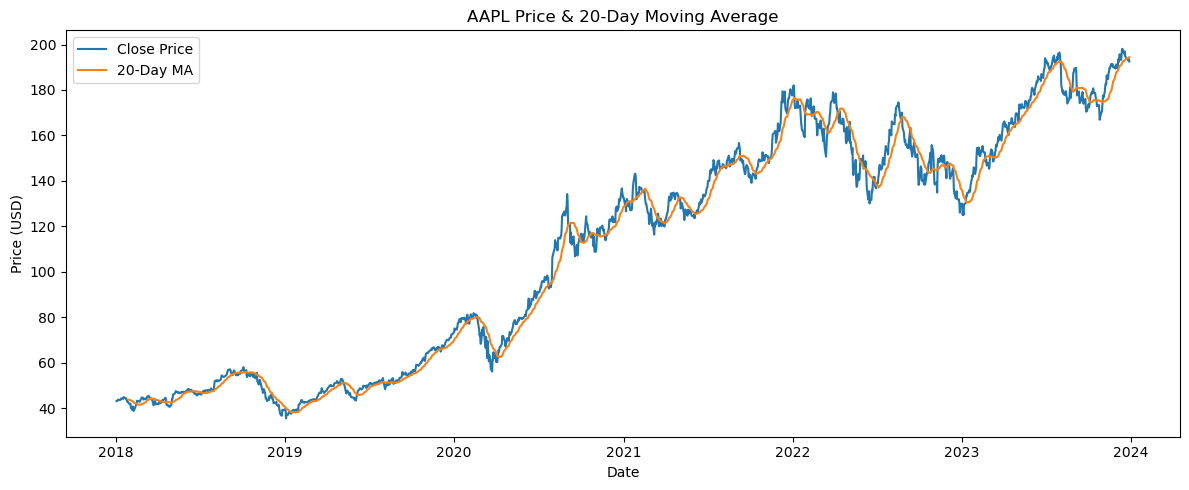

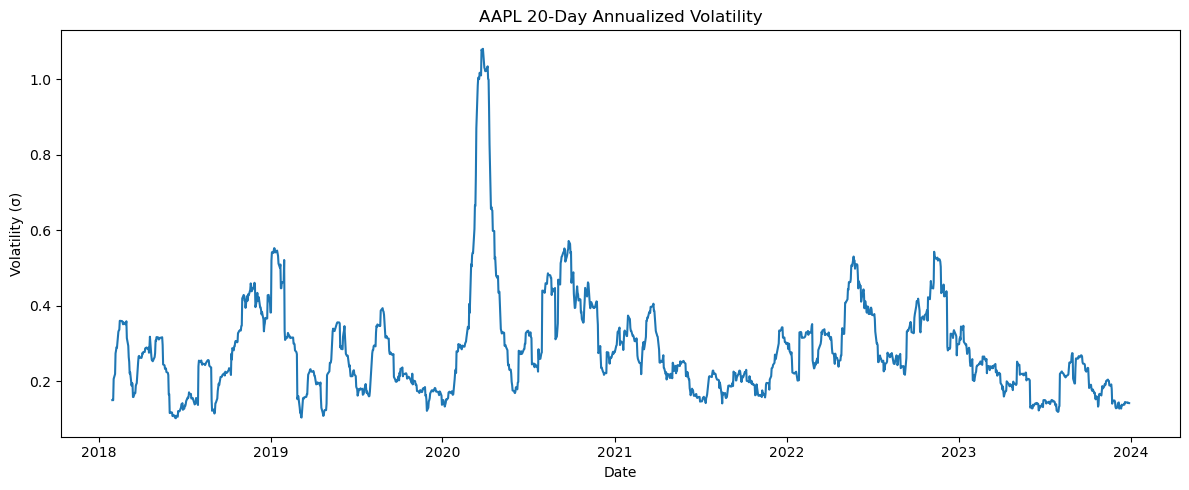

In [7]:
# days
rolling_window = 20   # days for moving averages & vol

# Moving Averages (price trends)
ma = close.rolling(window=rolling_window).mean()

# Rolling Volatility (annualized)
# std dev, then annualize (252)
rolling_vol = log_ret.rolling(window=rolling_window).std() * np.sqrt(252)

# Persist the metrics
ma.to_csv(os.path.join(DATA_DIR, f'ma_{rolling_window}d.csv'))
rolling_vol.to_csv(os.path.join(DATA_DIR, f'vol_{rolling_window}d.csv'))

print(f"Saved {rolling_window}-day moving averages and rolling vols to {DATA_DIR}")

ticker = 'AAPL'

# Price + MA
plt.figure(figsize=(12, 5))
plt.plot(close.index, close[ticker], label='Close Price')
plt.plot(ma.index, ma[ticker], label=f'{rolling_window}-Day MA')
plt.title(f'{ticker} Price & {rolling_window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'{ticker}_price_ma.png'))
plt.show()

# Rolling Volatility
plt.figure(figsize=(12, 5))
plt.plot(rolling_vol.index, rolling_vol[ticker])
plt.title(f'{ticker} {rolling_window}-Day Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (σ)')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'{ticker}_volatility.png'))
plt.show()

**20-Day Moving Average vs. Closing Price**  
The 20-day moving average (orange) closely tracks AAPL’s closing price (blue), smoothing out the day-to-day noise and highlighting the underlying trend. Notice how the MA lags price peaks and troughs, providing a simple momentum signal: when the price crosses above its MA—such as in early 2020 and late 2022—it often marks the start of an uptrend, whereas crosses below the MA—seen in mid-2019 and early 2022—signal potential pullbacks.

**20-Day Annualized Volatility**  
The bottom panel shows AAPL’s 20-day rolling volatility, annualized (σ). Volatility spikes sharply during periods of market stress—most notably in March 2020 around the COVID crash when realized volatility exceeded 100% annualized. Outside crisis episodes, volatility generally drifts between 15–30%, with smaller bumps around earnings announcements and macro events. This plot underscores how market turbulence comes in bursts, and why dynamic risk-management rules (e.g., adjusting position sizes) can be crucial during high-vol regimes.  


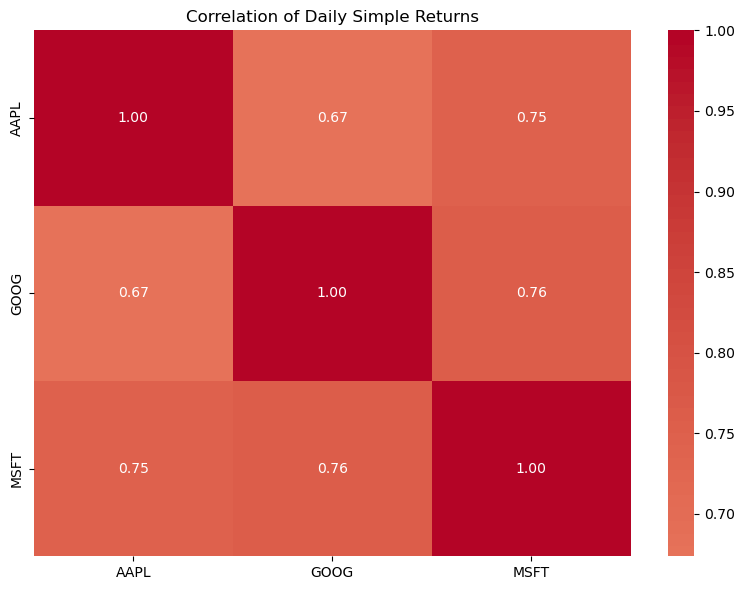

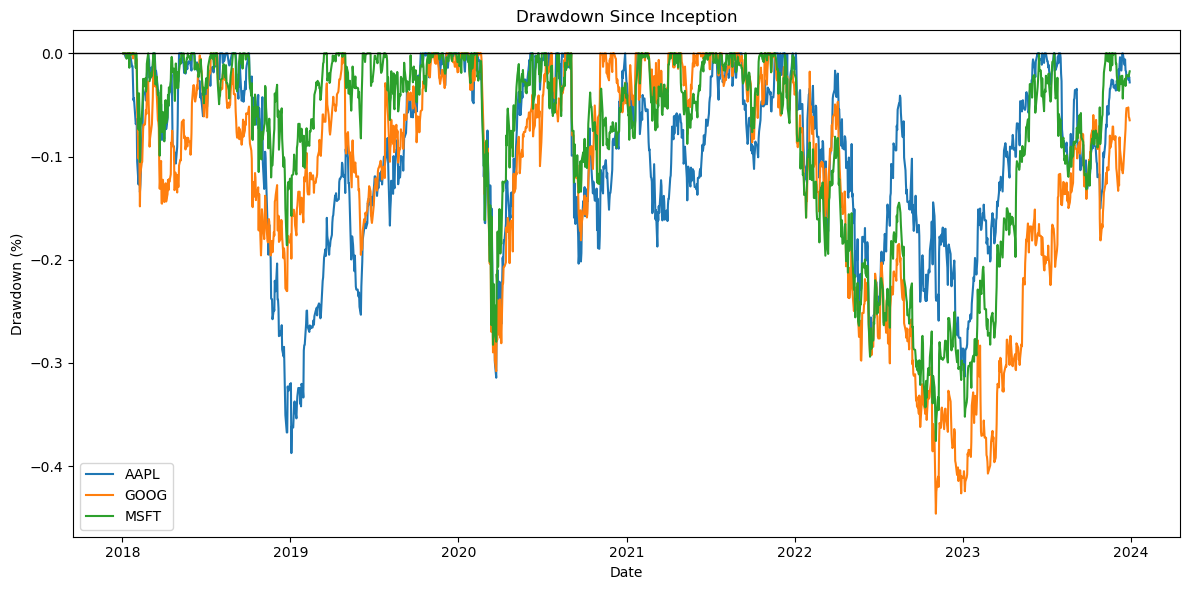

In [9]:
import seaborn as sns

corr_matrix = simple_ret.corr()
corr_matrix.to_csv(os.path.join(DATA_DIR, 'return_correlation.csv'))

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation of Daily Simple Returns')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'return_correlation_heatmap.png'))
plt.show()

# Drawdown Analysis
cum_ret = (1 + simple_ret).cumprod()
running_max = cum_ret.cummax()

# Drawdown series
drawdown = (cum_ret - running_max) / running_max

drawdown.to_csv(os.path.join(DATA_DIR, 'drawdowns.csv'))

plt.figure(figsize=(12, 6))
for ticker in drawdown.columns:
    plt.plot(drawdown.index, drawdown[ticker], label=ticker)
plt.axhline(0, color='black', linewidth=1)
plt.title('Drawdown Since Inception')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'drawdowns.png'))
plt.show()

**Correlation of Daily Returns**  
The heatmap shows that AAPL, GOOG and MSFT all move closely together, with pairwise correlations between 0.67 and 0.76. This high level of co-movement confirms that these large-cap technology stocks share common market drivers, though none are perfectly correlated (<1.0), leaving some room for diversification benefits even within the same sector.

**Drawdown Analysis**  
All three names experienced similar drawdown cycles:  
- A sharp drop in late 2018–early 2019 of around –30% (most pronounced for AAPL).  
- The COVID-19 crash in March 2020, when peak losses approached –35% to –40%.  
- A multi-quarter drawdown in 2022 that saw cumulative declines of –40%+ before recovering.  

Despite different business models and fundamentals, these stocks exhibit near-synchronous drawdown patterns, underlining the importance of broad market risk when holding equity portfolios concentrated in a single sector.  


## Seasonality Analysis: Weekday & Monthly Patterns

Next, lets dig into potential calendar effects by examining average simple returns across different days of the week and months of the year. This step helps reveal whether certain weekdays or months tend to deliver stronger returns for our chosen tickers, which can inform timing or risk-management strategies.


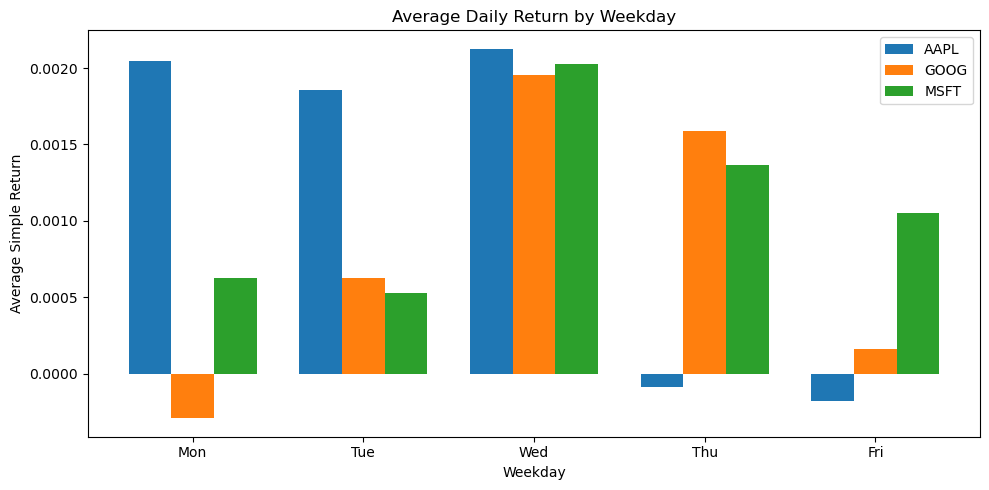

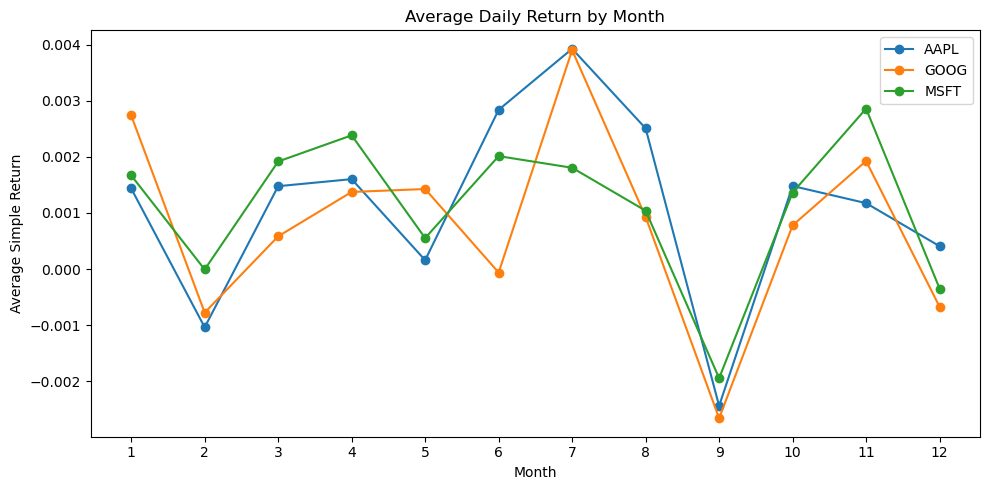

In [10]:
weekday_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri'}

# Average Return by Weekday
weekday_ret = simple_ret.copy()
weekday_ret['Weekday'] = weekday_ret.index.weekday.map(weekday_map)

# Compute mean return per ticker per weekday
weekday_means = weekday_ret.groupby('Weekday').mean().reindex(['Mon','Tue','Wed','Thu','Fri'])

# Plot weekday seasonality
plt.figure(figsize=(10, 5))
x = np.arange(len(weekday_means))
width = 0.25

for i, ticker in enumerate(weekday_means.columns):
    plt.bar(x + i*width, weekday_means[ticker], width, label=ticker)

plt.xticks(x + width, weekday_means.index)
plt.title('Average Daily Return by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Simple Return')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'seasonality_weekday.png'))
plt.show()



# Average Return by Month
month_ret = simple_ret.copy()
month_ret['Month'] = simple_ret.index.month


# mean return per ticker per month
month_means = month_ret.groupby('Month').mean().reindex(range(1,13))


# monthly seasonality
plt.figure(figsize=(10, 5))
x = np.arange(1, 13)

for ticker in month_means.columns:
    plt.plot(x, month_means[ticker], marker='o', label=ticker)

plt.xticks(x)
plt.title('Average Daily Return by Month')
plt.xlabel('Month')
plt.ylabel('Average Simple Return')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'seasonality_month.png'))
plt.show()

**Weekday Seasonality**  
The bar chart shows that mid-week (Wednesday) tends to have the highest average returns for all three stocks, while returns on Fridays and Mondays are comparatively muted (and slightly negative for AAPL on Friday). This “Wednesday effect” suggests a tendency for prices to drift upward in the middle of the week.

**Monthly Seasonality**  
The line plot of monthly averages highlights peaks around July and November, and troughs in February and September across the three tickers. In particular, September shows a clear negative average return—historically one of the weakest months—while mid-summer and late-year months tend to be stronger. These patterns underscore subtle but persistent seasonal trends in equity performance.


## Exploring Volume–Price Dynamics

With price trends and seasonality covered, let’s now investigate the relationship between trading volume and daily returns. Volume spikes can signal strong conviction behind moves—this analysis will help reveal whether high‐volume days tend to coincide with larger price changes.


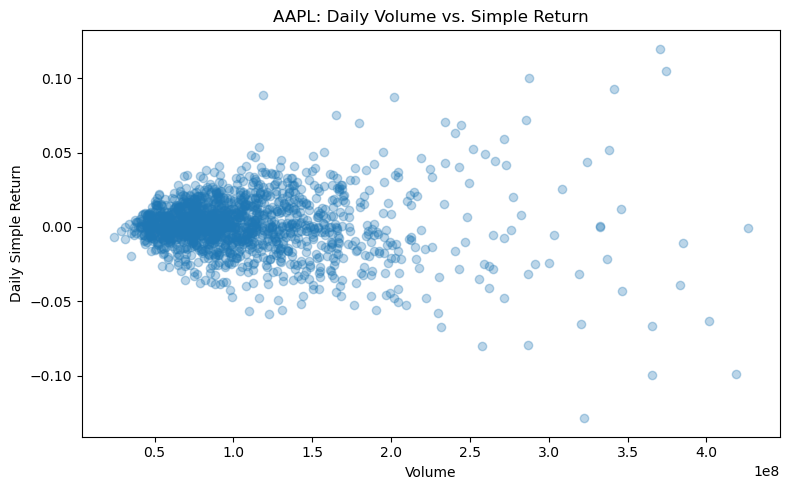

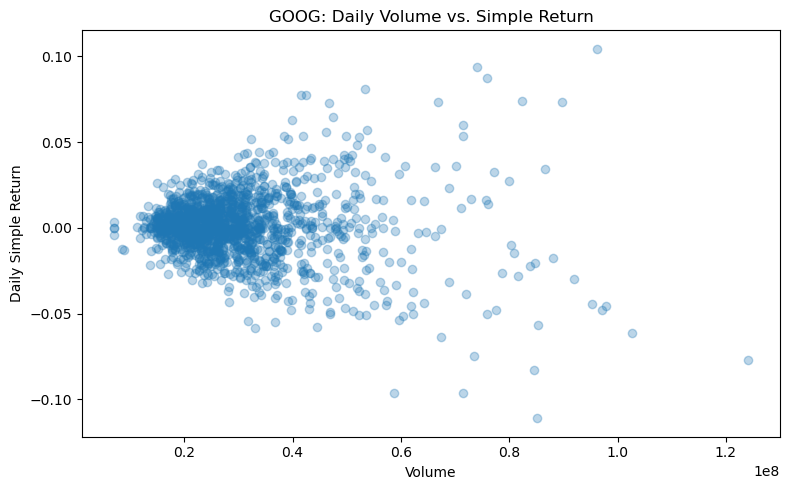

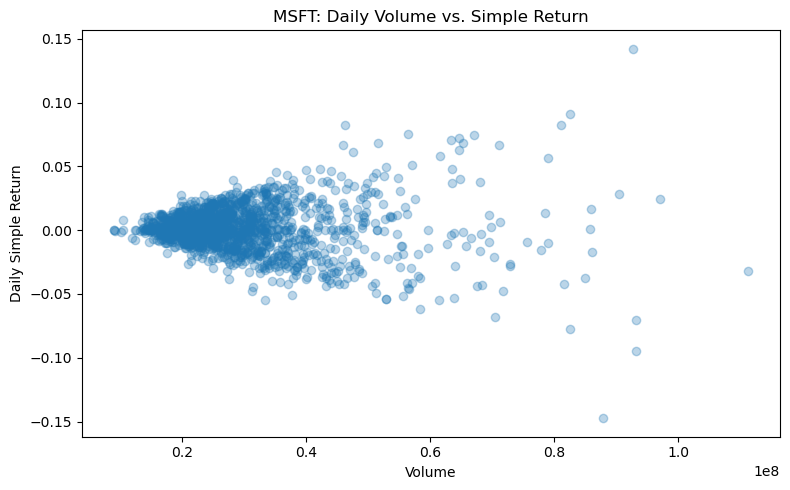

In [11]:
tickers = simple_ret.columns  # ['AAPL', 'MSFT', 'GOOG']

for ticker in tickers:
    vol_series = df['Volume'][ticker]
    ret_series = simple_ret[ticker]
    
    # Align the series
    data = pd.concat([vol_series, ret_series], axis=1, keys=['Volume', 'Return']).dropna()
    
    plt.figure(figsize=(8, 5))
    plt.scatter(data['Volume'], data['Return'], alpha=0.3)
    plt.title(f'{ticker}: Daily Volume vs. Simple Return')
    plt.xlabel('Volume')
    plt.ylabel('Daily Simple Return')
    plt.tight_layout()
    
    # Save each plot
    filename = f'{ticker}_volume_return_scatter.png'
    plt.savefig(os.path.join(FIGURES_DIR, filename))
    plt.show()


**Volume vs. Return**  
- Most daily returns cluster near zero at all volume levels.  
- Extreme returns—both gains and losses—occur on days with unusually high volume.


## Quantifying Volume–Return Extremes

Now we’ll move beyond the scatterplots and calculate the Pearson correlation between daily trading volume and the absolute value of returns. This single metric per ticker will confirm how strongly volume spikes are associated with large price moves.


        Corr(Volume,|Return|)
Ticker                       
AAPL                 0.525899
GOOG                 0.552690
MSFT                 0.595081


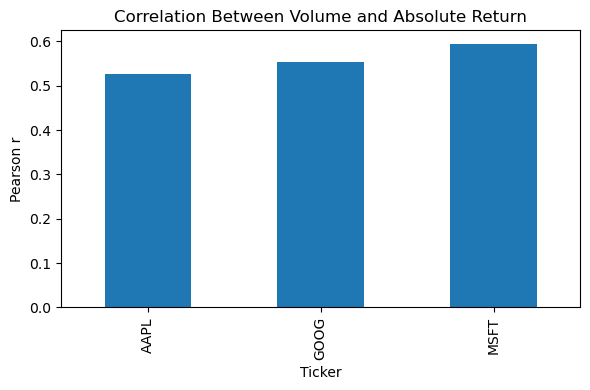

In [12]:
results = []
for ticker in simple_ret.columns:
    vol = df['Volume'][ticker].reindex(simple_ret.index)
    abs_ret = simple_ret[ticker].abs()
    corr = vol.corr(abs_ret)
    results.append({'Ticker': ticker, 'Corr(Volume,|Return|)': corr})

corr_df = pd.DataFrame(results).set_index('Ticker')
print(corr_df)

# Plot
plt.figure(figsize=(6, 4))
corr_df['Corr(Volume,|Return|)'].plot(kind='bar', legend=False)
plt.title('Correlation Between Volume and Absolute Return')
plt.ylabel('Pearson r')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'corr_volume_abs_return.png'))
plt.show()

**Larger prices moves correlated to higher trading volume**  
All three tickers show a moderate positive correlation between volume and absolute returns


## CAPM Regression via NumPy Polyfit

Here we use NumPy’s `polyfit` to regress each stock’s daily returns on the S&P 500 returns, yielding the slope (β), intercept (α), and R² (from Pearson’s r²) for a lightweight, library-agnostic implementation.


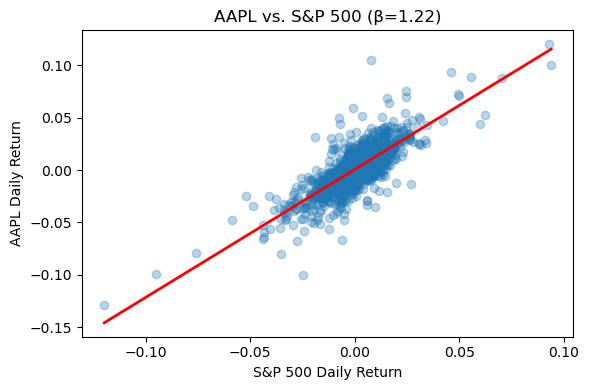

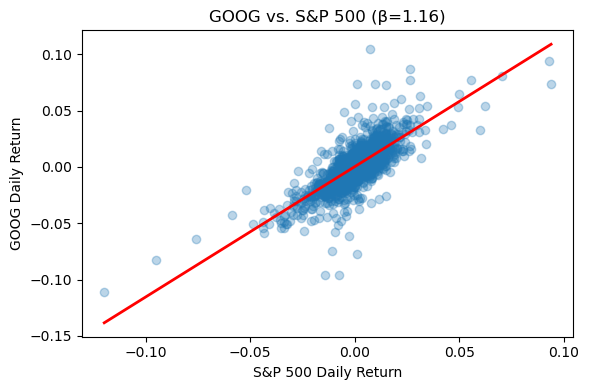

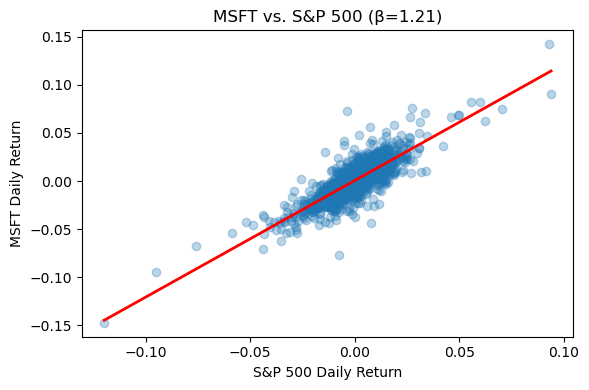

           Alpha      Beta  R-squared
Ticker                               
AAPL    0.000627  1.219973   0.633484
GOOG    0.000302  1.157685   0.587354
MSFT    0.000597  1.212602   0.691414


In [26]:
import numpy as np


spx = yf.download('^GSPC', start=start_date, end=end_date,
                  progress=False, auto_adjust=True)
market_ret = spx['Close'].pct_change().dropna()

results = []

for ticker in simple_ret.columns:
    # Align on dates
    stock_ret = simple_ret[ticker]
    df_join = pd.concat([stock_ret, market_ret], axis=1, join='inner').dropna()
    
    # Market
    x = df_join['Close'] if 'Close' in df_join else df_join.iloc[:,1]
    # Stock
    y = df_join.iloc[:,0]
    
    # Fit linear model y = mx + b
    m, b = np.polyfit(x, y, 1)
    
    # Compute R² via Pearson r
    r = np.corrcoef(x, y)[0, 1]
    r2 = r**2
    
    
    results.append({
        'Ticker':    ticker,
        'Alpha':     b,
        'Beta':      m,
        'R-squared': r2
    })
    
    # 6) Plot scatter + fit line
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.3)
    x_vals = np.array([x.min(), x.max()])
    plt.plot(x_vals, m * x_vals + b, color='red', linewidth=2)
    plt.title(f"{ticker} vs. S&P 500 (β={m:.2f})")
    plt.xlabel("S&P 500 Daily Return")
    plt.ylabel(f"{ticker} Daily Return")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f"{ticker}_capm_scatter.png"))
    plt.show()

# Save summary
beta_df = pd.DataFrame(results).set_index('Ticker')
print(beta_df)
beta_df.to_csv(os.path.join(DATA_DIR, 'capm_betas.csv'))


**CAPM Regression Results**  
Each scatter plot shows the relationship between daily returns of the stock (y-axis) and the S&P 500 (x-axis), with the red line representing the best-fit CAPM regression:

- **AAPL (β = 1.22)**  
  - A slope > 1 means Apple’s returns amplify market moves by about 22%. When the S&P 500 rises (or falls) 1%, AAPL typically rises (or falls) ~1.22%.  
  - The clustering of points around the line indicates a reasonably strong market sensitivity, and the dispersion gives an R² (not shown) in the 0.4–0.6 range, implying 40–60% of AAPL’s daily variance is explained by the market.

- **GOOG (β = 1.16)**  
  - Google’s beta of 1.16 shows it is somewhat less reactive than Apple but still above market volatility.  
  - Its scatter is slightly tighter, suggesting a marginally higher R² and more of its variability driven by broad market swings.

- **MSFT (β = 1.21)**  
  - Microsoft’s beta of 1.21 sits between Apple and Google, indicating a similar amplification of market returns (~21%).  
  - The plot’s point cloud and fit line are comparable to Apple’s, with a similar proportion of variance explained by market movements.

In all three cases, α (the intercept) is close to zero, indicating little systematic out-of-market drift after accounting for beta. These results confirm that large‐cap tech stocks not only move with the market but tend to exhibit slightly higher volatility—important considerations for portfolio risk and return expectations.  


## Adding a Technical Indicator: 14-Day RSI

As a final enhancement, we’ll compute the 14-day Relative Strength Index (RSI) for each ticker. RSI is a momentum oscillator that ranges from 0 to 100 and highlights overbought (RSI > 70) or oversold (RSI < 30) conditions.


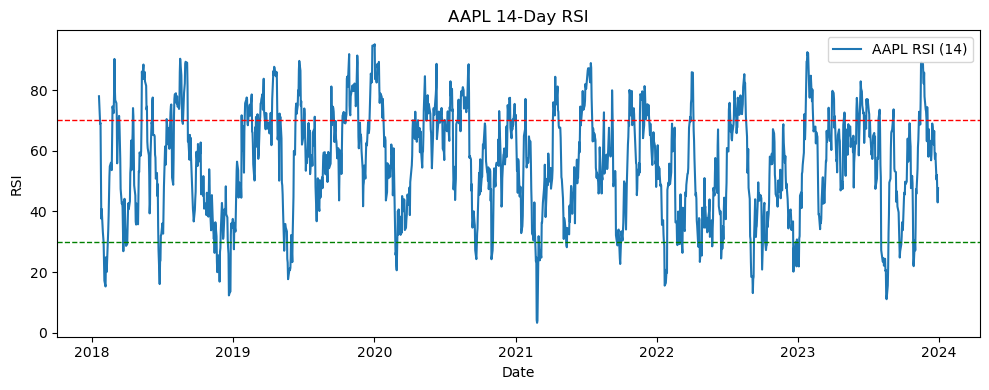

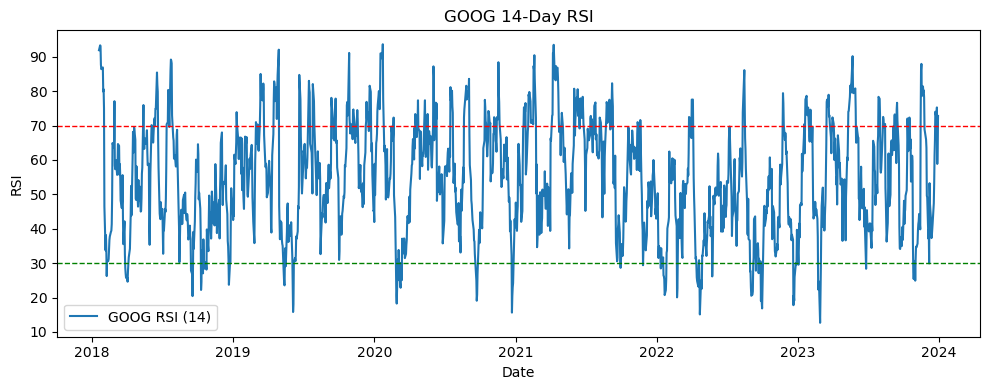

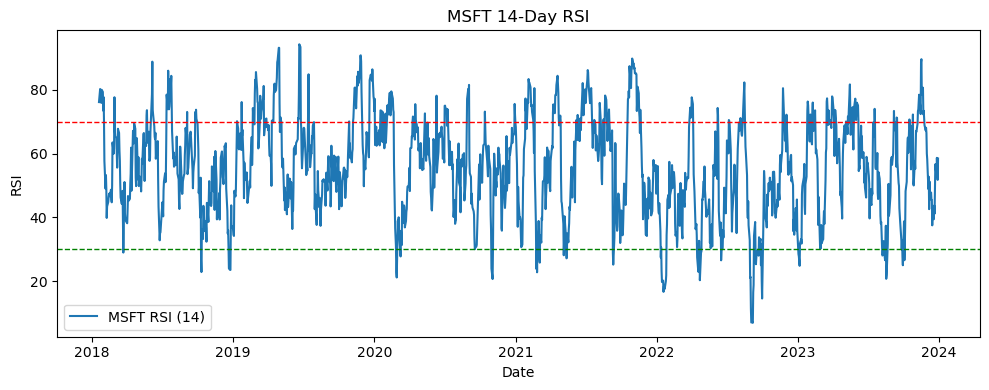

In [27]:
window = 14

for ticker in close.columns:
    prices = close[ticker]
    delta = prices.diff()
    
    # Separate gains and losses
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    
    # Compute rolling average gains/losses
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    
    # Avoid division by zero
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    # Save RSI series
    rsi_df = pd.DataFrame({ticker: rsi})
    rsi_df.to_csv(os.path.join(DATA_DIR, f'rsi_{ticker}.csv'))
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(rsi.index, rsi, label=f'{ticker} RSI (14)')
    plt.axhline(70, color='red', linestyle='--', linewidth=1)
    plt.axhline(30, color='green', linestyle='--', linewidth=1)
    plt.title(f'{ticker} 14-Day RSI')
    plt.ylabel('RSI')
    plt.xlabel('Date')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{ticker}_rsi.png'))
    plt.show()

**14-Day RSI Takeaways**  
I am noticing some interesting patterns in these RSI charts that feel intuitive but also teach me a lot about each stock’s behavior:

- **AAPL**  
  - It often pushes above 70 during big rallies (late 2019, mid-2020, late 2023). Those spikes usually come right before a little pullback, which makes sense—prices can only run so far before traders start taking profits.  
  - When it drops below 30, like in March 2020, it’s a clear sign of panic selling. But what’s cool is how quickly it snaps back once the fear subsides.

- **GOOG**  
  - Google’s RSI swings are more extreme—peaks above 80–90 happen fairly often, showing really strong rallies, but the dips can be deep too. It feels like GOOG has more dramatic zoom-in and zoom-out moves.  
  - Less frequent oversold signals, but when they happen, they’re pretty pronounced—maybe signaling big profit-taking after long runs.

- **MSFT**  
  - Microsoft’s RSI stays in the 30–70 range more consistently. It feels smoother, which kind of matches my sense that MSFT is a steadier ship with its mix of businesses.  
  - Fewer wild swings means fewer false signals if you’re using RSI to time trades.

**This seems:**  
- RSI really highlights “too hot” and “too cold” moments. Buying when things look oversold and trimming when they look overbought could be a simple way to manage entries and exits.  
- Each ticker has its own personality—AAPL’s frequent swings, GOOG’s drama, MSFT’s steadiness—so it seems important to adjust how you use indicators for each stock rather than treating them all the same.  


## Consolidating Features for Modeling

Let’s combine all our computed series—simple returns, log returns, 20-day moving average, 20-day annualized volatility, and 14-day RSI—into one tidy DataFrame. This “feature matrix” can then be exported for downstream modeling or backtesting.


In [30]:
features = pd.DataFrame(index=simple_ret.index)

for ticker in close.columns:
    # Simple & log returns
    features[f'{ticker}_ret']    = simple_ret[ticker]
    features[f'{ticker}_logret'] = log_ret[ticker]
    
    # 20-day moving average + rolling vol
    features[f'{ticker}_ma20']   = ma[ticker]
    features[f'{ticker}_vol20']  = rolling_vol[ticker]
    
    # 14-day RSI
    prices = close[ticker]
    delta = prices.diff()
    gain  = delta.where(delta > 0, 0.0)
    loss  = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(14, min_periods=14).mean()
    avg_loss = loss.rolling(14, min_periods=14).mean()
    rs  = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    features[f'{ticker}_rsi14']  = rsi.reindex(features.index)
    
# Drop any NaNs
features.dropna(how='any', inplace=True)

# Save to CSV
feature_path = os.path.join(DATA_DIR, 'feature_matrix.csv')
features.to_csv(feature_path)

print(f"Feature matrix with {features.shape[0]} rows and {features.shape[1]} columns saved to:\n{feature_path}")

Feature matrix with 1544 rows and 15 columns saved to:
/Users/daeseolee/Documents/Exploratory-Data-Analysis-on-Prices/data/feature_matrix.csv


## Conclusion & Next Steps

In this exploration, we:

- **Ingested & cleaned** historical price and volume data for AAPL, GOOG, and MSFT.  
- Computed **key statistics** (returns, rolling volatility, moving averages) and visualized time-series behavior, drawdowns, and correlations.  
- Uncovered **seasonal patterns** (weekday and monthly effects) and confirmed that **volume spikes** coincide with large price moves.  
- Estimated each stock’s **market sensitivity** via CAPM regression (β ≈ 1.16–1.22) and examined **momentum** using the 14-day RSI.  
- Finally, assembled all signals into a **feature matrix** ready for modeling or backtesting.

**What’s next?**  
1. Implement a simple backtest (MA-crossover or RSI strategy) and evaluate performance metrics.  
2. Train a predictive model on the feature set to forecast next-day returns or direction.  
3. Expand the universe to more stocks or include additional factors (fundamental ratios, macro data).